# Advance Lane Finding on Test images with Illustration

In [109]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    imag = cv2.imread(fname)
    gray = cv2.cvtColor(imag,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# Camera Calibration and Undistortion example

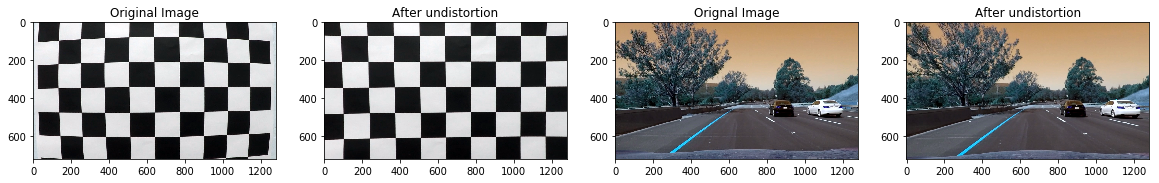

In [110]:
chess_img = cv2.imread('../camera_cal/calibration1.jpg')
road_img = cv2.imread('../test_images/test6.jpg')

chess_undistort = cv2.undistort(chess_img, mtx, dist, None, mtx)
road_undistort = cv2.undistort(road_img, mtx, dist, None, mtx)




f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize =(20,20))

ax1.imshow(chess_img)
ax1.set_title('Original Image')
ax2.imshow(chess_undistort)
ax2.set_title('After undistortion')
ax3.imshow(road_img)
ax3.set_title('Orignal Image')
ax4.imshow(road_undistort)
ax4.set_title('After undistortion')



In [111]:
def corners_unwarp(undst_img):
    img_size = (undst_img.shape[1], undst_img.shape[0])
    #src = np.float32([[580, 460],[710,460],[1150,720],[150,720]])
    src = np.float32([[280, 650],[1080,650],[800,490],[500,490]])
    #dst = np.float32([[100,gray.shape[0]],[200,0],[gray.shape[1],0],[gray.shape[1], gray.shape[0]]])
    dst = np.float32([[0,700],[1200,700],[1200,100],[0,100]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undst_img, M, img_size)
        
    return warped, M, Minv

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
 
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = 1280/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix


def region_of_interest(img, vertices):
        """
         Applies an image mask.
    
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   
    
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    
    

# Thresholding

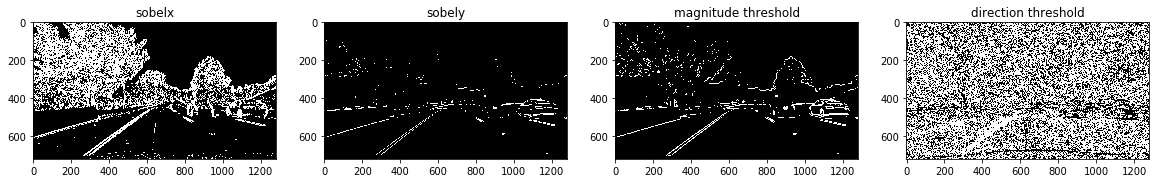

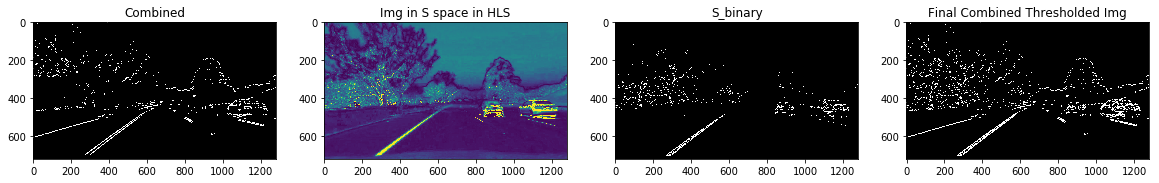

In [112]:
# Convert to HLS color space and separate the S channel

test_gray = cv2.cvtColor(road_undistort, cv2.COLOR_BGR2GRAY)
test_gray = cv2.GaussianBlur(test_gray,(9,9),0)
test_hls = cv2.cvtColor(road_undistort, cv2.COLOR_BGR2HLS)
test_s = test_hls[:,:,2]

test_sobelx = abs_sobel_thresh(test_gray, orient='x', thresh_min=10, thresh_max=255)

test_sobely= abs_sobel_thresh(test_gray, orient='y', thresh_min=85, thresh_max=255)

test_mag_thresh=mag_thresh(test_gray, sobel_kernel=11, mag_thresh=(80, 255))

test_dir_thresh =dir_threshold(road_undistort, sobel_kernel=11, thresh=(0.4,1.4))

test_combined = np.zeros_like(test_dir_thresh)
test_combined[((test_sobelx == 1) & (test_sobely == 1)) | ((test_mag_thresh == 1) & (test_dir_thresh == 1))] = 1

test_s_binary = np.zeros_like(test_combined)
test_s_binary[(test_s > 140) & (test_s < 255)] = 1

test_color_binary = np.zeros_like(test_combined)
test_color_binary[(test_s_binary > 0) | (test_combined > 0)] = 1

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))
ax1.set_title('sobelx')
ax1.imshow(test_sobelx, cmap='gray')
ax2.set_title('sobely')
ax2.imshow(test_sobely, cmap='gray')
ax3.set_title('magnitude threshold')
ax3.imshow(test_mag_thresh, cmap='gray')
ax4.set_title('direction threshold')
ax4.imshow(test_dir_thresh, cmap='gray')

f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,20))

ax1.set_title('Combined')
ax1.imshow(test_combined, cmap='gray')
ax2.set_title('Img in S space in HLS')
ax2.imshow(test_s)
ax3.set_title('S_binary')
ax3.imshow(test_s_binary, cmap='gray')
ax4.set_title('Final Combined Thresholded Img')
ax4.imshow(test_color_binary, cmap='gray')
#ax1.set_

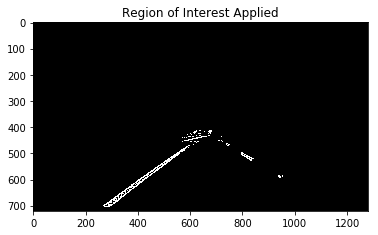

In [113]:
test_vertices = np.array([[(150,720),(610, 410), (680, 410), (1200,720)]], dtype=np.int32)

test_masked = region_of_interest(test_color_binary, test_vertices)

plt.imshow(test_masked, cmap='gray')
plt.title('Region of Interest Applied')


# Perspective Transform

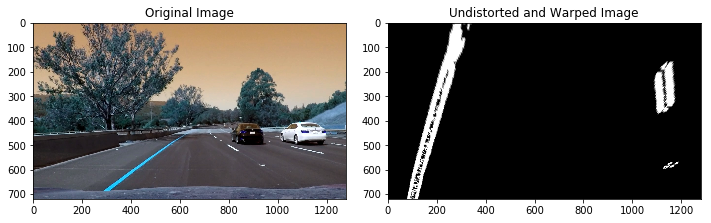

In [114]:
binary_warped, M, Minv= corners_unwarp(test_masked)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
f.tight_layout()
ax1.imshow(road_img)
ax1.set_title('Original Image')
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image')


# Detect lanes and fit 

80


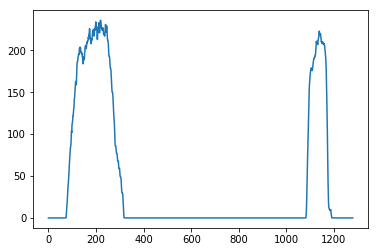

In [129]:
binary_warped[binary_warped > 0] = 1
histogram = np.sum(binary_warped[720//9:,:], axis=0)
plt.plot(histogram)


out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

print(window_height)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]



(720, 0)

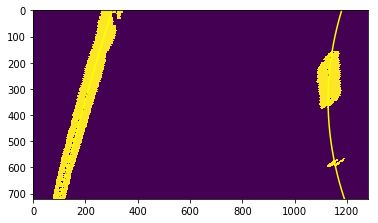

In [128]:
plt.imshow(binary_warped)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)




(720, 0)

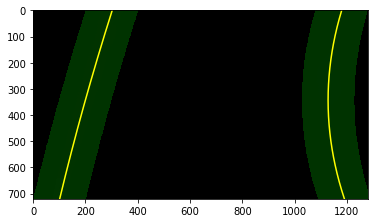

In [116]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Radius of Curvature

In [117]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print('Pixel Space')
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters

print('Real world space')
print(left_curverad, 'm', right_curverad, 'm')


Pixel Space
10019.9053371 1328.69336129
Real world space
3030.88766612 m 374.711183524 m


# Vehical Position

In [121]:
left_mean = np.mean(leftx)
right_mean = np.mean(rightx)
camera_pos = (test_combined.shape[1]/2)-np.mean([left_mean, right_mean])
vehical_pos = camera_pos*xm_per_pix

print(vehical_pos)

-0.16760990696


# Apply detected lane boundries

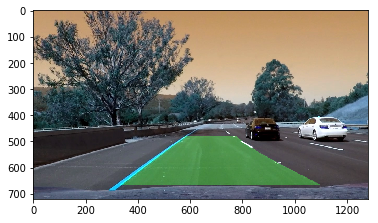

In [126]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (road_img.shape[1], road_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(road_img, 1, newwarp, 0.3, 0)

plt.imshow(result)

# Apply Text on image


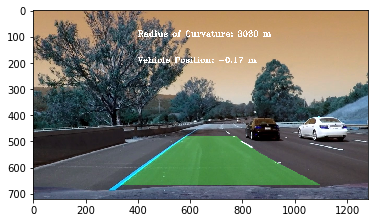

In [127]:
#Applying Text on image
    
font = cv2.FONT_HERSHEY_TRIPLEX
Roc_text = "Radius of Curvature: {} m".format(int(left_curverad))
VP_text = "Vehicle Position: {:.2f} m".format(vehical_pos)
    
cv2.putText(result,Roc_text,(400,100), font, 1,(255,255,255),2)
cv2.putText(result,VP_text,(400,200), font, 1,(255,255,255),2)

plt.imshow(result)